# Penny Crack example (3DT0)

This example involves a 2d circular crack, or a 'penny crack' in an infinite, isotropic medium. We use a triangular element with one collocation point to solve for the crack.

The following displacement boundary conditions are supplied when solving,
$$
D(x) = {8 (1-\nu^2) \sigma_A \over \pi E} \sqrt{r^2 - x^2}
$$

And the following traction solution is obtained,
$$
t(x) =
    \begin{cases}
        \sigma_A & \text{if } x \leq |r|\\
        0 & \text{if } x > |r|
    \end{cases}
$$

In [1]:
import numpy as np
import sys
import os
np.set_printoptions(precision=5, suppress=True)
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [3.5, 3.5]
plt.rcParams['font.size'] = 15
plt.rcParams['text.usetex']=True
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["text.latex.preamble"] = r'\usepackage{amsmath}'+ r'\usepackage{amssymb}' + r'\usepackage{accents}'+ r'\usepackage{bm}'+ r'\boldmath'+ r'\renewcommand{\v}[1]{\boldsymbol{{#1}}}'+ r'\DeclareRobustCommand{\sot}[1]{\boldsymbol{{#1}}}'

norm1 = lambda a : np.linalg.norm(a, axis=1)
norm = lambda a : np.linalg.norm(a)

from pathlib import Path
basefolder = "./data/"
Path(basefolder).mkdir(parents=True, exist_ok=True)

home = os.environ['HOME'] 

#change to the approprite bigwham directory and remember to place your notebook outside bigwham dir
sys.path.append(home + "/Desktop/GEL/BigWham/build/interfaces/python")
from hmatrix import Hmatrix  # linear operator file

h_array = []
rel_error_array = []

#Generate meshes first using generate_penny_mesh.py before proceeding to the further cells
#Minimum mesh size is about 0.005, but BigWham is unable to compute the solutions below 0.01 (FOR 32GB RAM)

In [2]:
h = 0.5
h_array.append(h)
os.environ["OMP_NUM_THREADS"] = "4"

radius = 1.0
pressure = 1.0

G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)

max_leaf_size = 16
eta = 3.0
eps_aca = 1e-3

coord = np.load(basefolder + "mesh_coords_%s.npy"%(h))
conn = np.load(basefolder + "mesh_conn_%s.npy"%(h))

# Create H-matrix
kernel = "3DT0"
hmat = Hmatrix(kernel, coord, conn, np.array([E, nu]), max_leaf_size, eta, eps_aca)

# hmat.write_hmatrix(basefolder + "hmat_%s.h5"%(h))

col_pts = hmat.getMeshCollocationPoints()

pre_fac = (8 * (1 - nu * nu)) / (np.pi * E)
dd = np.zeros(col_pts.shape)

#test code
#print(radius*radius - np.linalg.norm(col_pts[:,:2], axis=1)**2)

dd[:, 2] = pre_fac * np.sqrt(
    radius * radius - np.linalg.norm(col_pts[:, :2], axis=1) ** 2
)

print("Number of OMP threads {}".format(os.environ["OMP_NUM_THREADS"]))

# calculate tractions
t = hmat.matvec(dd.flatten())

t_anal = np.zeros(col_pts.shape)
t_anal[:, 2] = pressure

rel_err = np.linalg.norm(t - t_anal.flatten()) / t.shape[0]
print("L2 Rel error {}".format(rel_err))
rel_error_array.append(rel_err)

 Now setting things for kernel ... 3DT0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  1.8451e-05
Binary cluster tree depth = 2
Number of blocks = 16
Number of full blocks = 16
Number of low rank blocks = 0
Pattern Created 
 Loop on full blocks construction  
 N full blocks 16 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 3
Creation of hmat done in 0.0461979
Compression ratio - 1
Hmat object - built 
HMAT --> built 
HMAT set, CR = 1, eps_aca = 0.001, eta = 3
BigWhamIO ENDED
Number of OMP threads 4
L2 Rel error 0.006915449565032325


number of blocks 16
16 16


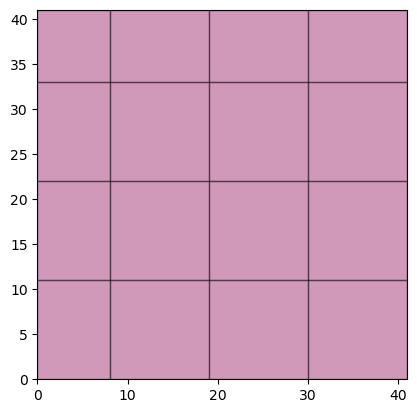

In [3]:
import matplotlib
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

#added the following command to deal with RuntimeError: Failed to process string with tex because latex could not be found
plt.rcParams.update(plt.rcParamsDefault)

# plt.rcParams['figure.figsize'] = [3.5, 3.5]
# plt.figure.figsize = [8, 8]

plt.figure(dpi=100)
ax = plt.gca()
data_pattern = hmat._getPattern()

patches = []
p_colors = []
max_y = data_pattern[:, 3].max()
for i in range(len(data_pattern)):
    height = np.abs(data_pattern[i, 0] - data_pattern[i, 2])
    width = np.abs(data_pattern[i, 1] - data_pattern[i, 3])
    y1 = max_y - data_pattern[i, 0] - height
    x1 = data_pattern[i, 1]
    rectangle = Rectangle((x1, y1), width, height)
    # print(x1, y1, width, height)
    patches.append(rectangle)
    p_colors.append(data_pattern[i, 4])

p = PatchCollection(
    patches, cmap=matplotlib.cm.PiYG, edgecolors="black", alpha=0.4
)
print(len(p_colors), len(patches))
p.set_array(np.array(p_colors))
ax.add_collection(p)
ax.set_ylim([data_pattern[:, 0].min(), data_pattern[:, 3].max()])
ax.set_xlim([data_pattern[:, 1].min(), data_pattern[:, 2].max()])
ax.set_aspect("equal")
plt.show()

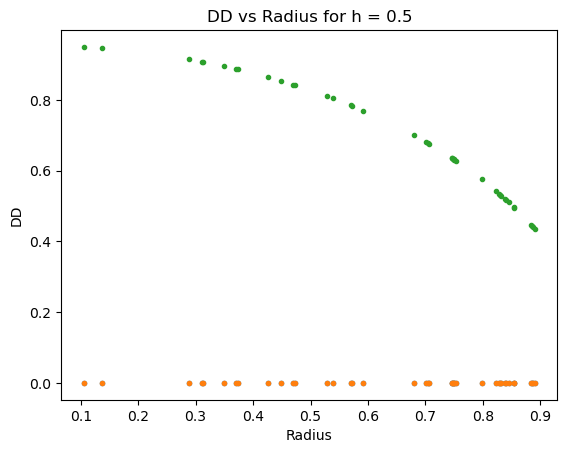

In [4]:
r = np.linalg.norm(col_pts[:, :2], axis=1)
plt.figure()
plt.plot(r, dd[:, :], ".")
plt.title("DD vs Radius for h = %s"%(h))
plt.xlabel("Radius")
plt.ylabel("DD")
plt.show()

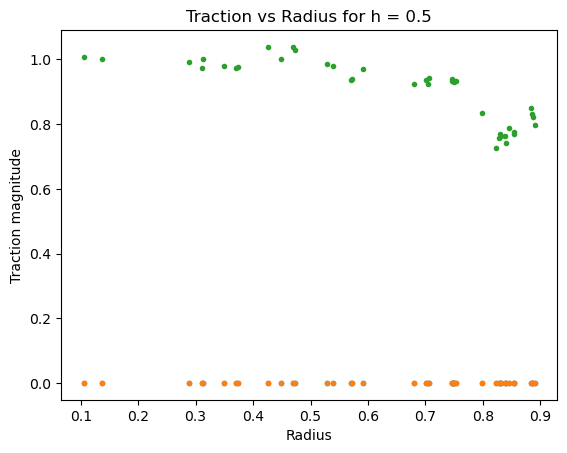

In [6]:
plt.figure()
plt.plot(r, t.reshape((-1, 3))[:, :], ".")
plt.title("Traction vs Radius for h = %s"%(h))
plt.xlabel("Radius")
plt.ylabel("Traction magnitude")
plt.show()

In [7]:
h = 0.25
h_array.append(h)
os.environ["OMP_NUM_THREADS"] = "4"

radius = 1.0
pressure = 1.0

G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)

max_leaf_size = 16
eta = 3.0
eps_aca = 1e-3

coord = np.load(basefolder + "mesh_coords_%s.npy"%(h))
conn = np.load(basefolder + "mesh_conn_%s.npy"%(h))

# Create H-matrix
kernel = "3DT0"
hmat = Hmatrix(kernel, coord, conn, np.array([E, nu]), max_leaf_size, eta, eps_aca)

# hmat.write_hmatrix(basefolder + "hmat_%s.h5"%(h))

col_pts = hmat.getMeshCollocationPoints()

pre_fac = (8 * (1 - nu * nu)) / (np.pi * E)
dd = np.zeros(col_pts.shape)

#test code
#print(radius*radius - np.linalg.norm(col_pts[:,:2], axis=1)**2)

dd[:, 2] = pre_fac * np.sqrt(
    radius * radius - np.linalg.norm(col_pts[:, :2], axis=1) ** 2
)

print("Number of OMP threads {}".format(os.environ["OMP_NUM_THREADS"]))

# calculate tractions
t = hmat.matvec(dd.flatten())

t_anal = np.zeros(col_pts.shape)
t_anal[:, 2] = pressure

rel_err = np.linalg.norm(t - t_anal.flatten()) / t.shape[0]
print("L2 Rel error {}".format(rel_err))
rel_error_array.append(rel_err)

Number of OMP threads 4
L2 Rel error 0.004916201357598054
 Now setting things for kernel ... 3DT0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  3.436e-05
Binary cluster tree depth = 4
Number of blocks = 127
Number of full blocks = 69
Number of low rank blocks = 58
Pattern Created 
 Loop on full blocks construction  
 N full blocks 69 
Loop on low rank blocks construction
N low rank blocks 58
dof_dimension: 3
Creation of hmat done in 0.0191415
Compression ratio - 1.08806
Hmat object - built 
HMAT --> built 
HMAT set, CR = 1.08806, eps_aca = 0.001, eta = 3
BigWhamIO ENDED


number of blocks 127
127 127


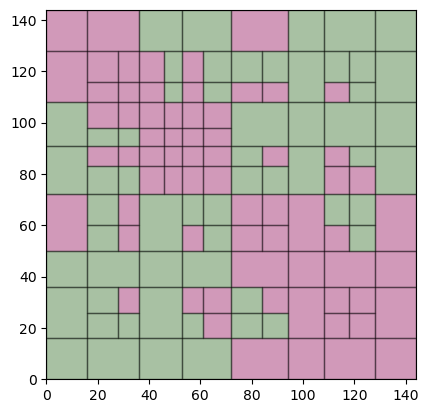

In [8]:
import matplotlib
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

#added the following command to deal with RuntimeError: Failed to process string with tex because latex could not be found
plt.rcParams.update(plt.rcParamsDefault)

# plt.rcParams['figure.figsize'] = [3.5, 3.5]
# plt.figure.figsize = [8, 8]

plt.figure(dpi=100)
ax = plt.gca()
data_pattern = hmat._getPattern()

patches = []
p_colors = []
max_y = data_pattern[:, 3].max()
for i in range(len(data_pattern)):
    height = np.abs(data_pattern[i, 0] - data_pattern[i, 2])
    width = np.abs(data_pattern[i, 1] - data_pattern[i, 3])
    y1 = max_y - data_pattern[i, 0] - height
    x1 = data_pattern[i, 1]
    rectangle = Rectangle((x1, y1), width, height)
    # print(x1, y1, width, height)
    patches.append(rectangle)
    p_colors.append(data_pattern[i, 4])

p = PatchCollection(
    patches, cmap=matplotlib.cm.PiYG, edgecolors="black", alpha=0.4
)
print(len(p_colors), len(patches))
p.set_array(np.array(p_colors))
ax.add_collection(p)
ax.set_ylim([data_pattern[:, 0].min(), data_pattern[:, 3].max()])
ax.set_xlim([data_pattern[:, 1].min(), data_pattern[:, 2].max()])
ax.set_aspect("equal")
plt.show()

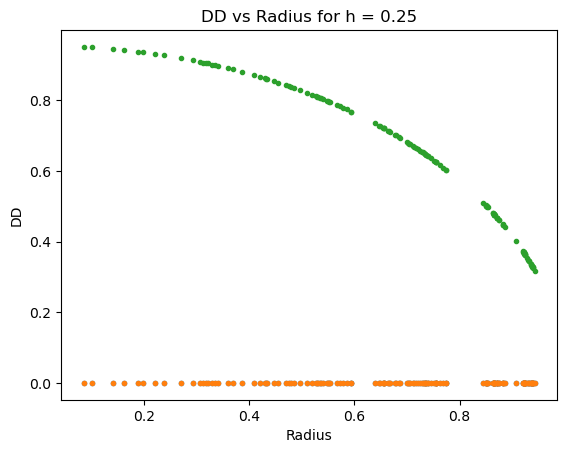

In [9]:
r = np.linalg.norm(col_pts[:, :2], axis=1)
plt.figure()
plt.plot(r, dd[:, :], ".")
plt.title("DD vs Radius for h = %s"%(h))
plt.xlabel("Radius")
plt.ylabel("DD")
plt.show()

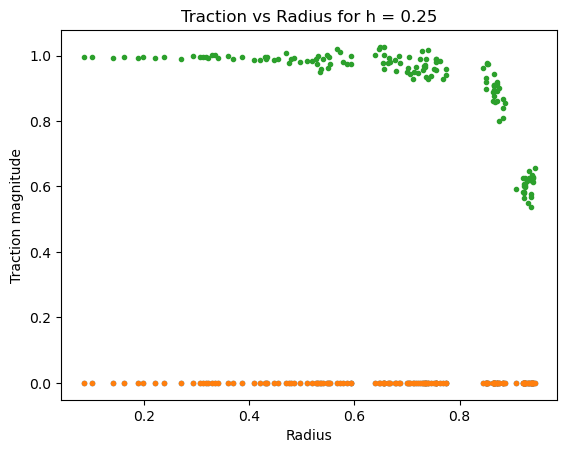

In [10]:
plt.figure()
plt.plot(r, t.reshape((-1, 3))[:, :], ".")
plt.title("Traction vs Radius for h = %s"%(h))
plt.xlabel("Radius")
plt.ylabel("Traction magnitude")
plt.show()

In [5]:
h = 0.1
h_array.append(h)
os.environ["OMP_NUM_THREADS"] = "4"

radius = 1.0
pressure = 1.0

G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)

max_leaf_size = 16
eta = 3.0
eps_aca = 1e-3

coord = np.load(basefolder + "mesh_coords_%s.npy"%(h))
conn = np.load(basefolder + "mesh_conn_%s.npy"%(h))

# Create H-matrix
kernel = "3DT0"
hmat = Hmatrix(kernel, coord, conn, np.array([E, nu]), max_leaf_size, eta, eps_aca)

# hmat.write_hmatrix(basefolder + "hmat_%s.h5"%(h))

col_pts = hmat.getMeshCollocationPoints()

pre_fac = (8 * (1 - nu * nu)) / (np.pi * E)
dd = np.zeros(col_pts.shape)

#test code
#print(radius*radius - np.linalg.norm(col_pts[:,:2], axis=1)**2)

dd[:, 2] = pre_fac * np.sqrt(
    radius * radius - np.linalg.norm(col_pts[:, :2], axis=1) ** 2
)

print("Number of OMP threads {}".format(os.environ["OMP_NUM_THREADS"]))

# calculate tractions
t = hmat.matvec(dd.flatten())

t_anal = np.zeros(col_pts.shape)
t_anal[:, 2] = pressure

rel_err = np.linalg.norm(t - t_anal.flatten()) / t.shape[0]
print("L2 Rel error {}".format(rel_err))
rel_error_array.append(rel_err)

 Now setting things for kernel ... 3DT0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  0.00203846
Binary cluster tree depth = 7
Number of blocks = 979
Number of full blocks = 401
Number of low rank blocks = 578
Pattern Created 
 Loop on full blocks construction  
 N full blocks 401 
Loop on low rank blocks construction
N low rank blocks 578
dof_dimension: 3
Creation of hmat done in 0.284738
Compression ratio - 0.579542
Hmat object - built 
HMAT --> built 
HMAT set, CR = 0.579542, eps_aca = 0.001, eta = 3
BigWhamIO ENDED
Number of OMP threads 4
L2 Rel error 0.002588258592242754


number of blocks 979
979 979


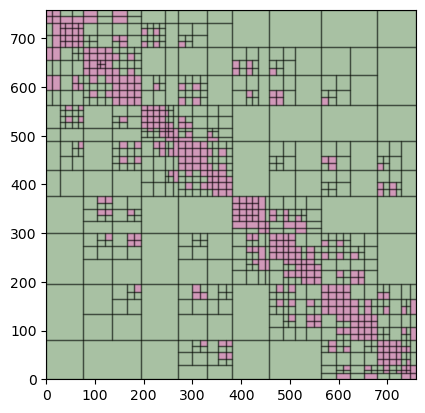

In [6]:
import matplotlib
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

#added the following command to deal with RuntimeError: Failed to process string with tex because latex could not be found
plt.rcParams.update(plt.rcParamsDefault)

# plt.rcParams['figure.figsize'] = [3.5, 3.5]
# plt.figure.figsize = [8, 8]

plt.figure(dpi=100)
ax = plt.gca()
data_pattern = hmat._getPattern()

patches = []
p_colors = []
max_y = data_pattern[:, 3].max()
for i in range(len(data_pattern)):
    height = np.abs(data_pattern[i, 0] - data_pattern[i, 2])
    width = np.abs(data_pattern[i, 1] - data_pattern[i, 3])
    y1 = max_y - data_pattern[i, 0] - height
    x1 = data_pattern[i, 1]
    rectangle = Rectangle((x1, y1), width, height)
    # print(x1, y1, width, height)
    patches.append(rectangle)
    p_colors.append(data_pattern[i, 4])

p = PatchCollection(
    patches, cmap=matplotlib.cm.PiYG, edgecolors="black", alpha=0.4
)
print(len(p_colors), len(patches))
p.set_array(np.array(p_colors))
ax.add_collection(p)
ax.set_ylim([data_pattern[:, 0].min(), data_pattern[:, 3].max()])
ax.set_xlim([data_pattern[:, 1].min(), data_pattern[:, 2].max()])
ax.set_aspect("equal")
plt.show()

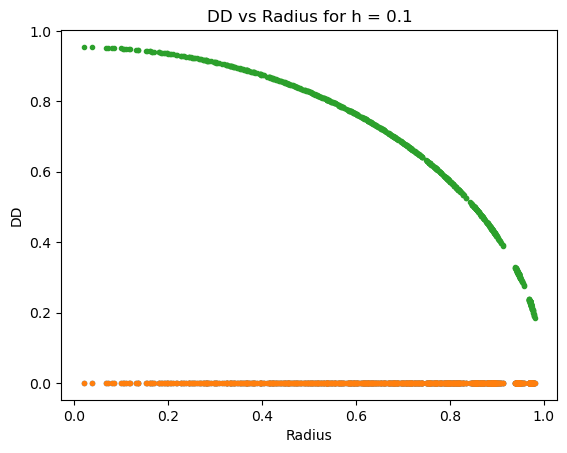

In [7]:
r = np.linalg.norm(col_pts[:, :2], axis=1)
plt.figure()
plt.plot(r, dd[:, :], ".")
plt.title("DD vs Radius for h = %s"%(h))
plt.xlabel("Radius")
plt.ylabel("DD")
plt.show()

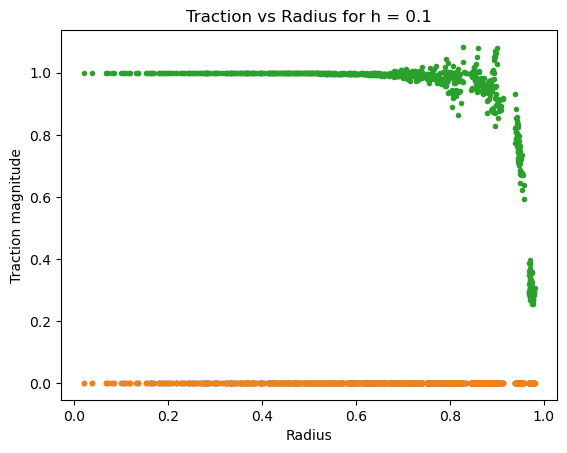

In [14]:
plt.figure()
plt.plot(r, t.reshape((-1, 3))[:, :], ".")
plt.title("Traction vs Radius for h = %s"%(h))
plt.xlabel("Radius")
plt.ylabel("Traction magnitude")
plt.show()

In [15]:
h = 0.05
h_array.append(h)
os.environ["OMP_NUM_THREADS"] = "4"

radius = 1.0
pressure = 1.0

G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)

max_leaf_size = 16
eta = 3.0
eps_aca = 1e-3

coord = np.load(basefolder + "mesh_coords_%s.npy"%(h))
conn = np.load(basefolder + "mesh_conn_%s.npy"%(h))

# Create H-matrix
kernel = "3DT0"
hmat = Hmatrix(kernel, coord, conn, np.array([E, nu]), max_leaf_size, eta, eps_aca)

# hmat.write_hmatrix(basefolder + "hmat_%s.h5"%(h))

col_pts = hmat.getMeshCollocationPoints()

pre_fac = (8 * (1 - nu * nu)) / (np.pi * E)
dd = np.zeros(col_pts.shape)

#test code
#print(radius*radius - np.linalg.norm(col_pts[:,:2], axis=1)**2)

dd[:, 2] = pre_fac * np.sqrt(
    radius * radius - np.linalg.norm(col_pts[:, :2], axis=1) ** 2
)

print("Number of OMP threads {}".format(os.environ["OMP_NUM_THREADS"]))

# calculate tractions
t = hmat.matvec(dd.flatten())

t_anal = np.zeros(col_pts.shape)
t_anal[:, 2] = pressure

rel_err = np.linalg.norm(t - t_anal.flatten()) / t.shape[0]
print("L2 Rel error {}".format(rel_err))
rel_error_array.append(rel_err)

 Now setting things for kernel ... 3DT0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  0.00290206
Binary cluster tree depth = 9
Number of blocks = 4936
Number of full blocks = 1830
Number of low rank blocks = 3106
Pattern Created 
 Loop on full blocks construction  
 N full blocks 1830 
Loop on low rank blocks construction
N low rank blocks 3106
dof_dimension: 3
Creation of hmat done in 2.01843
Compression ratio - 0.261373
Hmat object - built 
HMAT --> built 
HMAT set, CR = 0.261373, eps_aca = 0.001, eta = 3
BigWhamIO ENDED
Number of OMP threads 4
L2 Rel error 0.0013573110088500166


number of blocks 4936
4936 4936


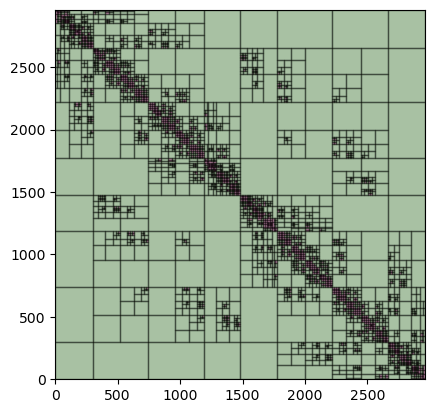

In [16]:
import matplotlib
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

#added the following command to deal with RuntimeError: Failed to process string with tex because latex could not be found
plt.rcParams.update(plt.rcParamsDefault)

# plt.rcParams['figure.figsize'] = [3.5, 3.5]
# plt.figure.figsize = [8, 8]

plt.figure(dpi=100)
ax = plt.gca()
data_pattern = hmat._getPattern()

patches = []
p_colors = []
max_y = data_pattern[:, 3].max()
for i in range(len(data_pattern)):
    height = np.abs(data_pattern[i, 0] - data_pattern[i, 2])
    width = np.abs(data_pattern[i, 1] - data_pattern[i, 3])
    y1 = max_y - data_pattern[i, 0] - height
    x1 = data_pattern[i, 1]
    rectangle = Rectangle((x1, y1), width, height)
    # print(x1, y1, width, height)
    patches.append(rectangle)
    p_colors.append(data_pattern[i, 4])

p = PatchCollection(
    patches, cmap=matplotlib.cm.PiYG, edgecolors="black", alpha=0.4
)
print(len(p_colors), len(patches))
p.set_array(np.array(p_colors))
ax.add_collection(p)
ax.set_ylim([data_pattern[:, 0].min(), data_pattern[:, 3].max()])
ax.set_xlim([data_pattern[:, 1].min(), data_pattern[:, 2].max()])
ax.set_aspect("equal")
plt.show()

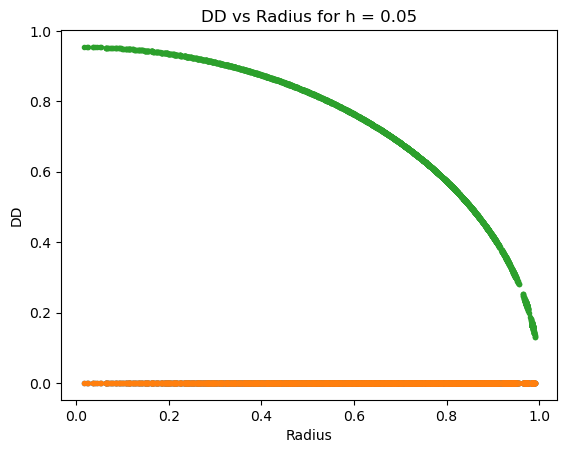

In [17]:
r = np.linalg.norm(col_pts[:, :2], axis=1)
plt.figure()
plt.plot(r, dd[:, :], ".")
plt.title("DD vs Radius for h = %s"%(h))
plt.xlabel("Radius")
plt.ylabel("DD")
plt.show()

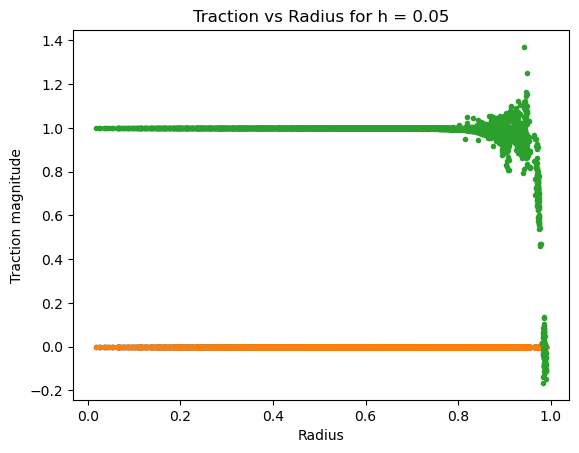

In [18]:
plt.figure()
plt.plot(r, t.reshape((-1, 3))[:, :], ".")
plt.title("Traction vs Radius for h = %s"%(h))
plt.xlabel("Radius")
plt.ylabel("Traction magnitude")
plt.show()

In [19]:
h = 0.025
h_array.append(h)
os.environ["OMP_NUM_THREADS"] = "4"

radius = 1.0
pressure = 1.0

G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)

max_leaf_size = 16
eta = 3.0
eps_aca = 1e-3

coord = np.load(basefolder + "mesh_coords_%s.npy"%(h))
conn = np.load(basefolder + "mesh_conn_%s.npy"%(h))

# Create H-matrix
kernel = "3DT0"
hmat = Hmatrix(kernel, coord, conn, np.array([E, nu]), max_leaf_size, eta, eps_aca)

# hmat.write_hmatrix(basefolder + "hmat_%s.h5"%(h))

col_pts = hmat.getMeshCollocationPoints()

pre_fac = (8 * (1 - nu * nu)) / (np.pi * E)
dd = np.zeros(col_pts.shape)

#test code
#print(radius*radius - np.linalg.norm(col_pts[:,:2], axis=1)**2)

dd[:, 2] = pre_fac * np.sqrt(
    radius * radius - np.linalg.norm(col_pts[:, :2], axis=1) ** 2
)

print("Number of OMP threads {}".format(os.environ["OMP_NUM_THREADS"]))

# calculate tractions
t = hmat.matvec(dd.flatten())

t_anal = np.zeros(col_pts.shape)
t_anal[:, 2] = pressure

rel_err = np.linalg.norm(t - t_anal.flatten()) / t.shape[0]
print("L2 Rel error {}".format(rel_err))
rel_error_array.append(rel_err)

 Now setting things for kernel ... 3DT0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  0.0148894
Binary cluster tree depth = 11
Number of blocks = 21529
Number of full blocks = 7581
Number of low rank blocks = 13948
Pattern Created 
 Loop on full blocks construction  
 N full blocks 7581 
Loop on low rank blocks construction
N low rank blocks 13948
dof_dimension: 3
Creation of hmat done in 12.5701
Compression ratio - 0.0982499
Hmat object - built 
HMAT --> built 
HMAT set, CR = 0.0982499, eps_aca = 0.001, eta = 3
BigWhamIO ENDED
Number of OMP threads 4
L2 Rel error 0.0006879882760646388


number of blocks 21529
21529 21529


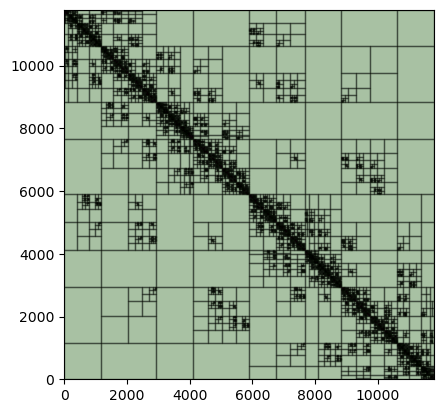

In [20]:
import matplotlib
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

#added the following command to deal with RuntimeError: Failed to process string with tex because latex could not be found
plt.rcParams.update(plt.rcParamsDefault)

# plt.rcParams['figure.figsize'] = [3.5, 3.5]
# plt.figure.figsize = [8, 8]

plt.figure(dpi=100)
ax = plt.gca()
data_pattern = hmat._getPattern()

patches = []
p_colors = []
max_y = data_pattern[:, 3].max()
for i in range(len(data_pattern)):
    height = np.abs(data_pattern[i, 0] - data_pattern[i, 2])
    width = np.abs(data_pattern[i, 1] - data_pattern[i, 3])
    y1 = max_y - data_pattern[i, 0] - height
    x1 = data_pattern[i, 1]
    rectangle = Rectangle((x1, y1), width, height)
    # print(x1, y1, width, height)
    patches.append(rectangle)
    p_colors.append(data_pattern[i, 4])

p = PatchCollection(
    patches, cmap=matplotlib.cm.PiYG, edgecolors="black", alpha=0.4
)
print(len(p_colors), len(patches))
p.set_array(np.array(p_colors))
ax.add_collection(p)
ax.set_ylim([data_pattern[:, 0].min(), data_pattern[:, 3].max()])
ax.set_xlim([data_pattern[:, 1].min(), data_pattern[:, 2].max()])
ax.set_aspect("equal")
plt.show()

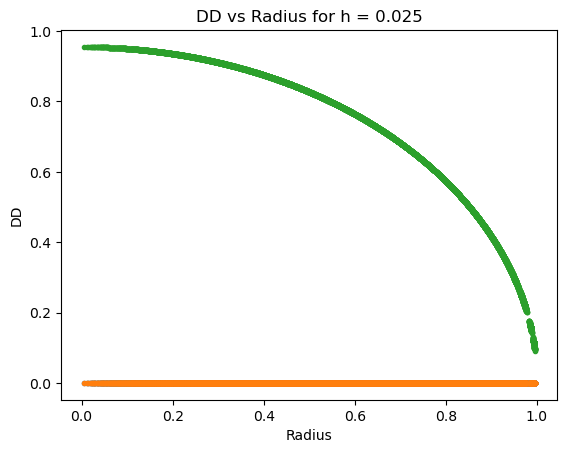

In [21]:
r = np.linalg.norm(col_pts[:, :2], axis=1)
plt.figure()
plt.plot(r, dd[:, :], ".")
plt.title("DD vs Radius for h = %s"%(h))
plt.xlabel("Radius")
plt.ylabel("DD")
plt.show()

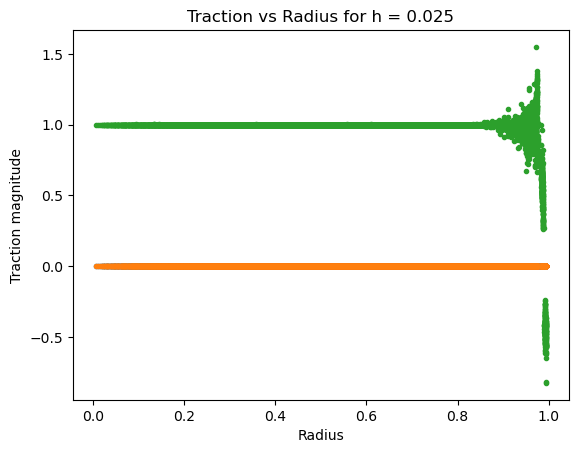

In [22]:
plt.figure()
plt.plot(r, t.reshape((-1, 3))[:, :], ".")
plt.title("Traction vs Radius for h = %s"%(h))
plt.xlabel("Radius")
plt.ylabel("Traction magnitude")
plt.show()

In [23]:
h = 0.01
h_array.append(h)
os.environ["OMP_NUM_THREADS"] = "4"

radius = 1.0
pressure = 1.0

G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)

max_leaf_size = 16
eta = 3.0
eps_aca = 1e-3

coord = np.load(basefolder + "mesh_coords_%s.npy"%(h))
conn = np.load(basefolder + "mesh_conn_%s.npy"%(h))

# Create H-matrix
kernel = "3DT0"
hmat = Hmatrix(kernel, coord, conn, np.array([E, nu]), max_leaf_size, eta, eps_aca)

# hmat.write_hmatrix(basefolder + "hmat_%s.h5"%(h))

col_pts = hmat.getMeshCollocationPoints()

pre_fac = (8 * (1 - nu * nu)) / (np.pi * E)
dd = np.zeros(col_pts.shape)

#test code
#print(radius*radius - np.linalg.norm(col_pts[:,:2], axis=1)**2)

dd[:, 2] = pre_fac * np.sqrt(
    radius * radius - np.linalg.norm(col_pts[:, :2], axis=1) ** 2
)

print("Number of OMP threads {}".format(os.environ["OMP_NUM_THREADS"]))

# calculate tractions
t = hmat.matvec(dd.flatten())

t_anal = np.zeros(col_pts.shape)
t_anal[:, 2] = pressure

rel_err = np.linalg.norm(t - t_anal.flatten()) / t.shape[0]
print("L2 Rel error {}".format(rel_err))
rel_error_array.append(rel_err)

 Now setting things for kernel ... 3DT0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  0.131505
Binary cluster tree depth = 13
Number of blocks = 168964
Number of full blocks = 53154
Number of low rank blocks = 115810
Pattern Created 
 Loop on full blocks construction  
 N full blocks 53154 
Loop on low rank blocks construction
N low rank blocks 115810
dof_dimension: 3
Creation of hmat done in 119.856
Compression ratio - 0.0234037
Hmat object - built 
HMAT --> built 
HMAT set, CR = 0.0234037, eps_aca = 0.001, eta = 3
BigWhamIO ENDED
Number of OMP threads 4
L2 Rel error 0.0002806289257341606


number of blocks 168964
168964 168964


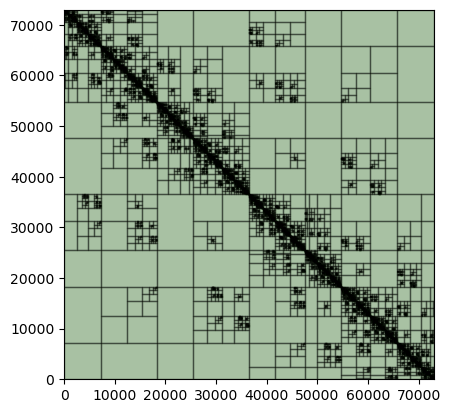

In [24]:
import matplotlib
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

#added the following command to deal with RuntimeError: Failed to process string with tex because latex could not be found
plt.rcParams.update(plt.rcParamsDefault)

# plt.rcParams['figure.figsize'] = [3.5, 3.5]
# plt.figure.figsize = [8, 8]

plt.figure(dpi=100)
ax = plt.gca()
data_pattern = hmat._getPattern()

patches = []
p_colors = []
max_y = data_pattern[:, 3].max()
for i in range(len(data_pattern)):
    height = np.abs(data_pattern[i, 0] - data_pattern[i, 2])
    width = np.abs(data_pattern[i, 1] - data_pattern[i, 3])
    y1 = max_y - data_pattern[i, 0] - height
    x1 = data_pattern[i, 1]
    rectangle = Rectangle((x1, y1), width, height)
    # print(x1, y1, width, height)
    patches.append(rectangle)
    p_colors.append(data_pattern[i, 4])

p = PatchCollection(
    patches, cmap=matplotlib.cm.PiYG, edgecolors="black", alpha=0.4
)
print(len(p_colors), len(patches))
p.set_array(np.array(p_colors))
ax.add_collection(p)
ax.set_ylim([data_pattern[:, 0].min(), data_pattern[:, 3].max()])
ax.set_xlim([data_pattern[:, 1].min(), data_pattern[:, 2].max()])
ax.set_aspect("equal")
plt.show()

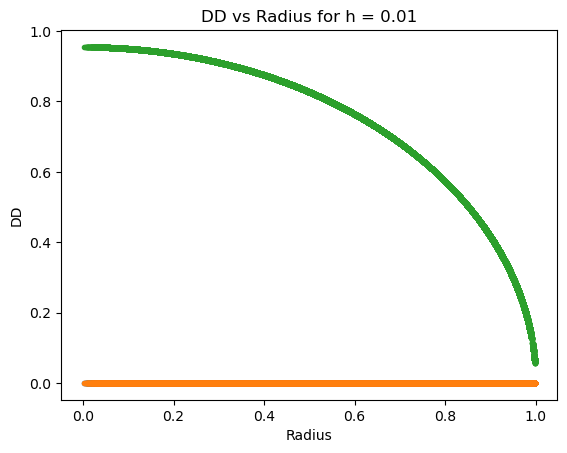

In [25]:
r = np.linalg.norm(col_pts[:, :2], axis=1)
plt.figure()
plt.plot(r, dd[:, :], ".")
plt.title("DD vs Radius for h = %s"%(h))
plt.xlabel("Radius")
plt.ylabel("DD")
plt.show()

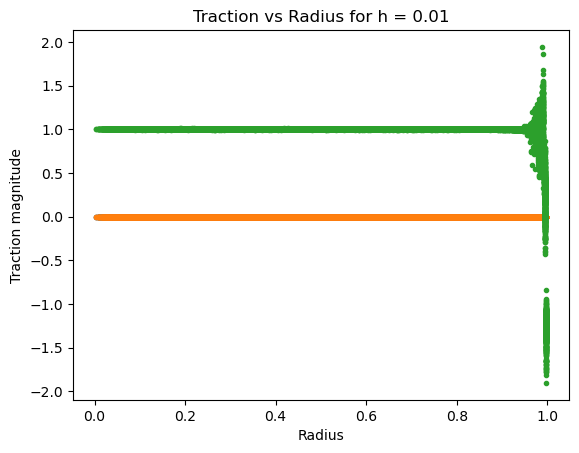

In [26]:
plt.figure()
plt.plot(r, t.reshape((-1, 3))[:, :], ".")
plt.title("Traction vs Radius for h = %s"%(h))
plt.xlabel("Radius")
plt.ylabel("Traction magnitude")
plt.show()

In [27]:
import numpy as np
import matplotlib.pyplot as plt

h_array = [0.5, 0.25, 0.1, 0.05, 0.025, 0.01]
rel_error_array = [0.006915449565032325, 0.004916201357598054, 0.0025882585922427535, 0.0013573110088500166, 0.0006879882760646388, 0.0002806289257341606]

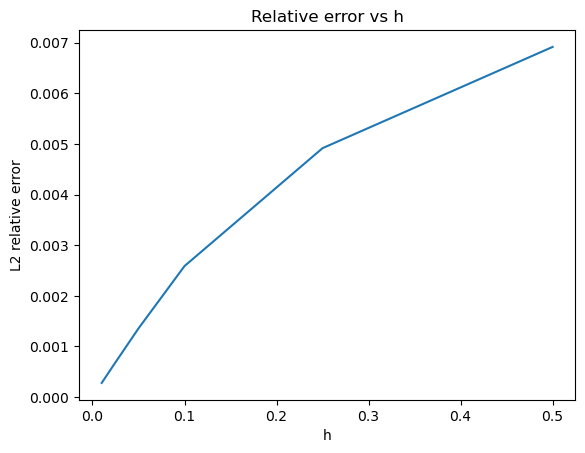

In [28]:
plt.figure()
plt.plot(h_array, rel_error_array)
plt.title("Relative error vs h")
plt.xlabel("h")
plt.ylabel("L2 relative error")
#saves fig - remember to remove
#plt.savefig('rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

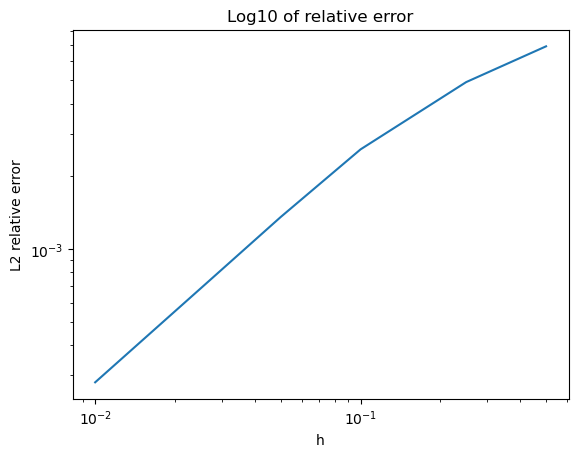

In [29]:
plt.figure()
plt.plot(h_array, rel_error_array)
plt.title("Log10 of relative error")
plt.xlabel("h")
plt.ylabel("L2 relative error")
plt.yscale('log')
plt.xscale('log')
#saves fig - remember to remove
#plt.savefig('log_rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

In [30]:
log_h = np.log(np.asarray(h_array)[2:])
log_rel_array = np.log(np.asarray(rel_error_array)[2:])

m, c = np.polyfit(log_h, log_rel_array, 1)

print(m)
print(c)

0.9668417460987205
-3.7193919860571456


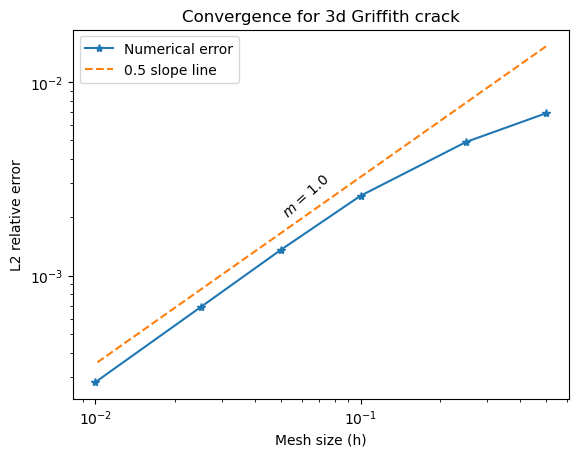

In [39]:
%matplotlib inline

plt.figure()
plt.plot(h_array, rel_error_array, "*-")
plt.plot(h_array, 0.03 * np.array(h_array) ** m , "--")
plt.title("Convergence for 3d Griffith crack")

plt.text(0.05, 0.002, r'$m$' + ' = 1.0', rotation=42)
plt.legend(["Numerical error", "0.5 slope line"])

plt.xlabel("Mesh size (h)")
plt.ylabel("L2 relative error")
plt.yscale('log',base=10)
plt.xscale('log',base=10)
#saves fig - remember to remove
# plt.savefig('log2_rel_err_h.png', dpi=100, bbox_inches='tight')
# plt.show()